In [1]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta, datetime
import time
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd
from vnpy.trader.utils import htmlplot

In [2]:
SOB = []
Signal = []

class SOBStrategy(CtaTemplate):
    """MoMStrategy"""
    className = 'MoMStrategy'
    author = 'yuanhongjian'
    
    
    # 策略参数（与参数列表对应）
    # 参数设置

    SOBthres = 15
    SOBexit = -10
    SOBlookback = 50
    
    lot = 10000          # 设置手数
    
    # 仓位管理参数
    stopRatio = 0.02
    
    nPos = 0
    fixsize = 1000
    Ratio = 0.02
    proportion = 2
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['ShortMoMPeriod','LongMoMPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
#        self.onBarfixedaddposition(bar)
#        self.onBarStopLoss(bar)
        pass
    def onBarfixedaddposition(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
    # 固定损失加仓激进版模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 4):    # 持有多头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if lastOrder/bar.close-1 >= self.Ratio/self.proportion: 
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.buy(symbol,bar.close*1.02, add_fixsize)  # 加仓数量
                self.fixsize = add_fixsize + self.fixsize
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 4):    # 持有空头仓位并且加仓次数不超过3次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if bar.close/lastOrder-1>= self.Ratio/self.proportion:
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.short(symbol,bar.close*0.98,self.fixsize)  # 目标仓位100手，分别加仓25手、20手、15手，10手
                self.fixsize = add_fixsize + self.fixsize       
    
        
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
        # 发出状态更新事件
        self.putEvent()
    
        #----------------------------------------------------------------------
    def get_sob(self, close_seq):
    # get SOB statistic
        if close_seq[-1] > close_seq[-2]:
            # SOB > 1
            sob = 2
            for i in range(3, self.SOBlookback+1):
                if close_seq[-1] > close_seq[-i]:
                    sob += 1
                else:
                    break
        else:
            # SOB < -1
            sob = -2
            for i in range(3, self.SOBlookback+1):
                if close_seq[-1] < close_seq[-i]:
                    sob += -1
                else:
                    break
        return sob
    

    def get_signal(self, SOB):
        if len(SOB) < self.SOBlookback:
            signal = 0
        else:
            if SOB[-1] >= SOB[-2]:
                signal = 2
                for i in range(3, self.SOBlookback + 1):
                    if SOB[-1] >= SOB[-i]:
                        signal += 1
                    else:
                        break
            else:
                signal = -2
                for i in range(3, self.SOBlookback + 1):
                    if SOB[-1] <= SOB[-i]:
                        signal += -1
                    else:
                        break
        return signal

     #----------------------------------------------------------------------
    
    
    def on15MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "15m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        # 指标计算
    
        sob = self.get_sob(am.close)
        SOB.append(sob)
        signal = self.get_signal(SOB)
        Signal.append(signal)

        # 现象条件
       
        BuySOB = (SOB[-1] > self.SOBthres) and (Signal[-1] == self.SOBlookback)
        SellSOB = (SOB[-1] < self.SOBexit) and (Signal[-1] == -self.SOBlookback)
        
        
        # 构建进出场逻辑-------------------------------------------------
        if BuySOB and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif SellSOB and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass
    


仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2019-01-23 10:15:24.775821	开始回测
2019-01-23 10:15:24.775887	策略初始化
2019-01-23 10:15:25.722158	数据载入完成, 时间段:[20180528 08:00,20180601 12:00);数据量:5700
2019-01-23 10:15:25.722478	初始化预加载数据成功, 数据长度:5700
2019-01-23 10:15:25.722569	策略初始化完成
2019-01-23 10:15:25.722617	策略启动完成
2019-01-23 10:15:25.722706	回测时间范围:[20180601 12:00,20181201 12:00)
2019-01-23 10:15:25.722785	当前回放的时间段:[20180601 12:00,20181201 12:00)
2019-01-23 10:15:47.218581	数据载入完成, 时间段:[20180601 12:00,20181201 12:00);数据量:261728
2019-01-23 10:15:47.534966	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2019-01-23 10:15:48.751206	数据载入完成, 时间段:[20180523 00:45,20180531 20:50);数据量:4790
2019-01-23 10:15:48.754886	WARNING: 该时间段:[20180603 12:01,20180603 12:15) 数据量为0!
2019-01-23 10:16:08.827248	回放结束ress: 100%    
2019-01-23 10:16:08.842924	策略日志已生成
2019-01-23 10:16:08.843118	计算按日统计结果
2019-01-23 10:16:08.945575	------------------------------
2019-01-23 10:16:08.945990	首个交易日：	

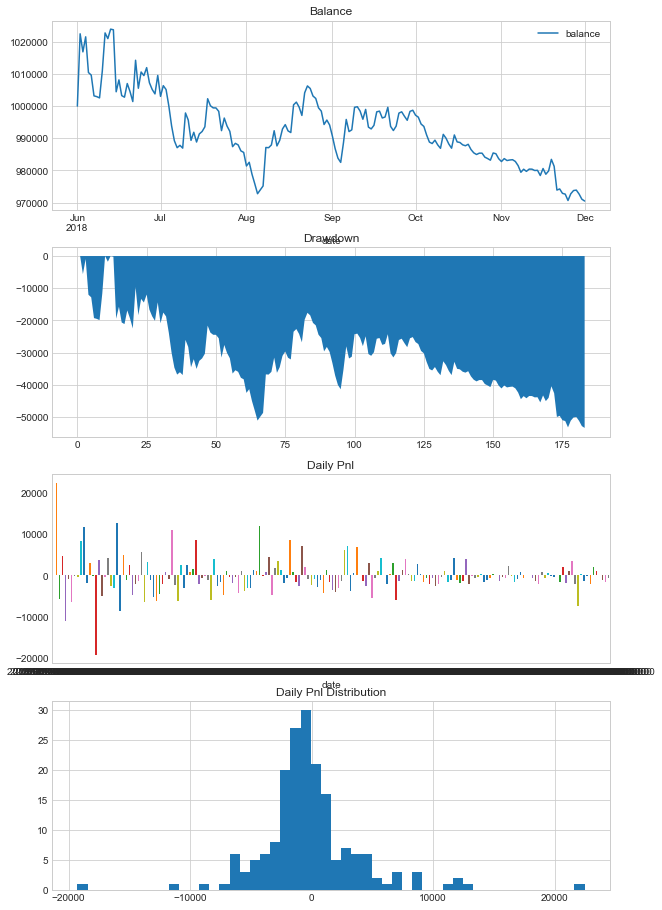

2019-01-23 10:16:13.181499	计算回测结果
2019-01-23 10:16:13.244404	交割单已生成
2019-01-23 10:16:13.246209	------------------------------
2019-01-23 10:16:13.246586	第一笔交易：	2018-06-03 05:00:00
2019-01-23 10:16:13.246678	最后一笔交易：	2018-12-01 11:58:00
2019-01-23 10:16:13.246754	总交易次数：	419
2019-01-23 10:16:13.246832	总盈亏：	-29,554.95
2019-01-23 10:16:13.246919	最大回撤: 	-58,216.4
2019-01-23 10:16:13.246988	平均每笔盈利：	-70.54
2019-01-23 10:16:13.247037	平均每笔滑点：	40.0
2019-01-23 10:16:13.247122	平均每笔佣金：	65.88
2019-01-23 10:16:13.247291	胜率		34.61%
2019-01-23 10:16:13.247341	盈利交易平均值	2,354.49
2019-01-23 10:16:13.247400	亏损交易平均值	-1,353.86
2019-01-23 10:16:13.247456	盈亏比：	1.74
2019-01-23 10:16:14.376970	策略回测统计图已保存


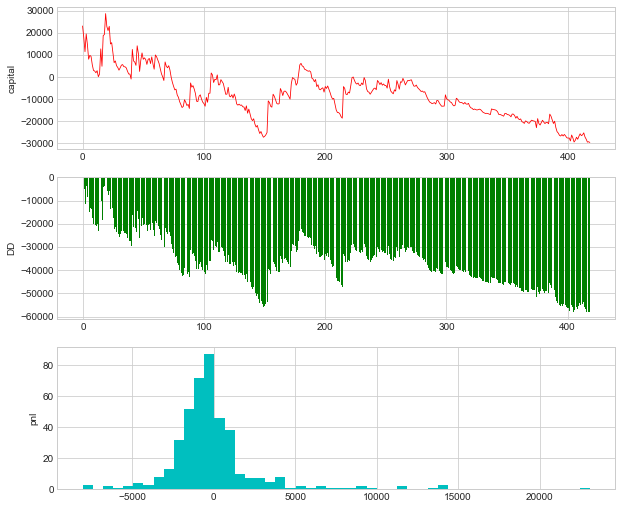

/Users/yuanhongjian/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.17-py3.6.egg/vnpy/trader/utils/htmlplot/core.py:8: UserWarning: Expected version of bokeh is 0.12.14, current version is 0.12.7
  warnings.warn("Expected version of bokeh is 0.12.14, current version is %s" % bokeh.__version__)


2019-01-23 10:16:17.977647	计算按日统计结果


In [3]:
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=100)
    engine.setEndDate(endDate)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.setLog(True)
    
#   在这里设置画图参数，目前只用设置freqency，支持的有 s(second) m(minute) h(hour) d(day)，也可以用timestamp, 例如： 1h -> timestamp(hours=1)
#   sample(输出用4hbar画图)
#   画图需要安装bokeh==0.12.14
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(1000000)
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    htmlplot.showTransaction(engine, frequency="1h")
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('tradeDatetime')
    return engine
#     return perfromanceDf, tradeDf

runBacktesting(SOBStrategy, {'symbolList': [
                                                    'EOSUSDT:binance',
#                                                             'eos_quarter:OKEX'
                                                        ]},
                                                           '20180601 12:00', 
#                                                               '20181006 12:00', 
                                                           '20181201 12:00',0.002, 5/10000)